# *(Jansen & Rit, 1995)*: Jansen-Rit Model

The Jansen-Rit model, a neural mass model of the dynamic interactions between 3 populations:

- pyramidal cells (PCs)
- excitatory interneurons (EINs)
- inhibitory interneurons (IINs)

Originally, the model has been developed to describe the waxing-and-waning
of EEG activity in the alpha frequency range (8-12 Hz) in the visual cortex [1].
In the past years, however, it has been used as a generic model to describe
the macroscopic electrophysiological activity within a cortical column [2].

By using the linearity of the convolution operation, the dynamic interactions between PCs, EINs and IINs can be
expressed via 6 coupled ordinary differential equations that are composed of the two operators defined above:

$$
\begin{aligned}
\dot V_{pce} &= I_{pce}, \\
\dot I_{pce} &= \frac{H_e}{\tau_e} c_4 S(c_3 V_{in}) - \frac{2 I_{pce}}{\tau_e} - \frac{V_{pce}}{\tau_e^2}, \\
\dot V_{pci} &= I_{pci}, \\
\dot I_{pci} &= \frac{H_i}{\tau_i} c_2 S(c_1 V_{in}) - \frac{2 I_{pci}}{\tau_i} - \frac{V_{pci}}{\tau_i^2}, \\
\dot V_{in} &= I_{in}, \\
\dot I_{in} &= \frac{H_e}{\tau_e} S(V_{pce} - V_{pci}) - \frac{2 I_{in}}{\tau_e} - \frac{V_{in}}{\tau_e^2},
\end{aligned}
$$

where $V_{pce}$, $V_{pci}$, $V_{in}$ are used to represent the average membrane potential
deflection caused by the excitatory synapses at the PC population, the inhibitory synapses at the PC
population, and the excitatory synapses at both interneuron populations, respectively.

- [1] B.H. Jansen & V.G. Rit (1995) Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns. Biological Cybernetics, 73(4): 357-366.
       
- [2] A. Spiegler, S.J. Kiebel, F.M. Atay, T.R. Knösche (2010) Bifurcation analysis of neural mass models: Impact of extrinsic inputs and dendritic time constants. NeuroImage, 52(3): 1041-1058, https://doi.org/10.1016/j.neuroimage.2009.12.081.

In [1]:
import brainpy as bp
import brainpy.math as bm

In [2]:
class JansenRitModel(bp.dyn.DynamicalSystem):
  def __init__(self, num, C=135., method='exp_auto'):
    super(JansenRitModel, self).__init__()

    self.num = num

    # parameters #
    self.v_max = 5.  # maximum firing rate
    self.v0 = 6.  # firing threshold
    self.r = 0.56  # slope of the sigmoid
    # other parameters
    self.A = 3.25
    self.B = 22.
    self.a = 100.
    self.tau_e = 0.01  # second
    self.tau_i = 0.02  # second
    self.b = 50.
    self.e0 = 2.5
    # The connectivity constants
    self.C1 = C
    self.C2 = 0.8 * C
    self.C3 = 0.25 * C
    self.C4 = 0.25 * C

    # variables #
    # y0, y1 and y2 representing the firing rate of
    # pyramidal, excitatory and inhibitory neurones.
    self.y0 = bm.Variable(bm.zeros(self.num))
    self.y1 = bm.Variable(bm.zeros(self.num))
    self.y2 = bm.Variable(bm.zeros(self.num))
    self.y3 = bm.Variable(bm.zeros(self.num))
    self.y4 = bm.Variable(bm.zeros(self.num))
    self.y5 = bm.Variable(bm.zeros(self.num))
    self.p = bm.Variable(bm.ones(self.num) * 220.)

    # integral function
    self.derivative = bp.JointEq([self.dy0, self.dy1, self.dy2, self.dy3, self.dy4, self.dy5])
    self.integral = bp.odeint(self.derivative, method=method)

  def sigmoid(self, x):
    return self.v_max / (1. + bm.exp(self.r * (self.v0 - x)))

  def dy0(self, y0, t, y3): return y3

  def dy1(self, y1, t, y4): return y4

  def dy2(self, y2, t, y5): return y5

  def dy3(self, y3, t, y0, y1, y2):
    return (self.A * self.sigmoid(y1 - y2) - 2 * y3 - y0 / self.tau_e) / self.tau_e

  def dy4(self, y4, t, y0, y1, p):
    return (self.A * (p + self.C2 * self.sigmoid(self.C1 * y0)) - 2 * y4 - y1 / self.tau_e) / self.tau_e

  def dy5(self, y5, t, y0, y2):
    return (self.B * self.C4 * self.sigmoid(self.C3 * y0) - 2 * y5 - y2 / self.tau_i) / self.tau_i

  def update(self, tdi):
    self.y0.value, self.y1.value, self.y2.value, self.y3.value, self.y4.value, self.y5.value = \
      self.integral(self.y0, self.y1, self.y2, self.y3, self.y4, self.y5, tdi.t, p=self.p, dt=tdi.dt)

In [3]:
def simulation(duration=5.):
  dt = 0.1 / 1e3
  # random input uniformly distributed between 120 and 320 pulses per second
  all_ps = bm.random.uniform(120, 320, size=(int(duration / dt), 1))
  jrm = JansenRitModel(num=6, C=bm.array([68., 128., 135., 270., 675., 1350.]))
  runner = bp.dyn.DSRunner(jrm,
                           monitors=['y0', 'y1', 'y2', 'y3', 'y4', 'y5'],
                           inputs=['p', all_ps, 'iter', '='],
                           dt=dt)
  runner.run(duration)

  start, end = int(2 / dt), int(duration / dt)
  fig, gs = bp.visualize.get_figure(6, 3, 2, 3)
  for i in range(6):
    fig.add_subplot(gs[i, 0])
    title = 'E' if i == 0 else None
    xlabel = 'time [s]' if i == 5 else None
    bp.visualize.line_plot(runner.mon.ts[start: end], runner.mon.y1[start: end, i],
                           title=title, xlabel=xlabel, ylabel='Hz')
    fig.add_subplot(gs[i, 1])
    title = 'P' if i == 0 else None
    bp.visualize.line_plot(runner.mon.ts[start: end], runner.mon.y0[start: end, i],
                           title=title, xlabel=xlabel)
    fig.add_subplot(gs[i, 2])
    title = 'I' if i == 0 else None
    bp.visualize.line_plot(runner.mon.ts[start: end], runner.mon.y2[start: end, i],
                           title=title, show=i==5, xlabel=xlabel)

  0%|          | 0/50000 [00:00<?, ?it/s]

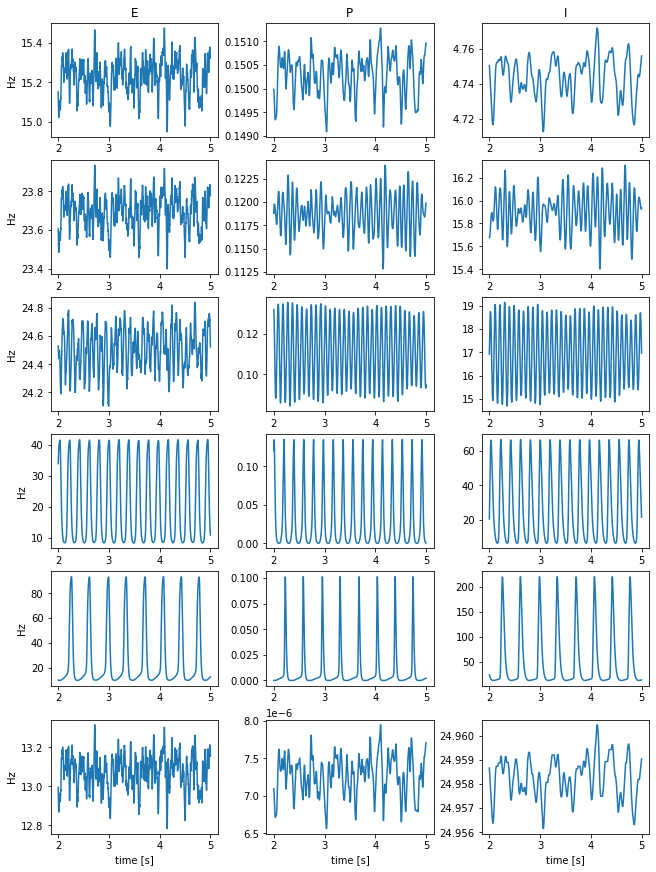

In [4]:
simulation()